In [42]:
# Importing Libraries
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

from sklearn.preprocessing import MinMaxScaler
from arch import arch_model
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from keras.models import Sequential
from keras.layers import Dense, LSTM
import math
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv("/Users/meetsudra/Documents/GitHub/ATM Cash Forecasting/stock_details_5_years.csv")
df.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,Company
0,2018-11-29 00:00:00-05:00,43.829761,43.863354,42.639594,43.083508,167080000,0.00,0.0,AAPL
1,2018-11-29 00:00:00-05:00,104.769074,105.519257,103.534595,104.636131,28123200,0.00,0.0,MSFT
2,2018-11-29 00:00:00-05:00,54.176498,55.007500,54.099998,54.729000,31004000,0.00,0.0,GOOGL
3,2018-11-29 00:00:00-05:00,83.749496,84.499496,82.616501,83.678497,132264000,0.00,0.0,AMZN
4,2018-11-29 00:00:00-05:00,39.692784,40.064904,38.735195,39.037853,54917200,0.04,0.0,NVDA


In [3]:
df = df[df["Company"] == "TSLA"]
df.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,Company
6,2018-11-29 00:00:00-05:00,23.133333,23.166668,22.636667,22.744667,46210500,0.0,0.0,TSLA
464,2018-11-30 00:00:00-05:00,22.788668,23.440001,22.550667,23.365334,84436500,0.0,0.0,TSLA
922,2018-12-03 00:00:00-05:00,24.000000,24.400000,23.466667,23.899332,124597500,0.0,0.0,TSLA
1380,2018-12-04 00:00:00-05:00,23.736668,24.578667,23.466667,23.980000,126928500,0.0,0.0,TSLA
1838,2018-12-06 00:00:00-05:00,23.733999,24.492001,23.384001,24.204000,117637500,0.0,0.0,TSLA


In [4]:
#The columns represent:
#Open: Opening price of the stock
#High: Highest price during the trading day
#Low: Lowest price during the trading day
#Close: Closing price of the stock
#Volume: Number of shares traded

In [5]:
# Handling missing values 
df.isnull().sum()

Date            0
Open            0
High            0
Low             0
Close           0
Volume          0
Dividends       0
Stock Splits    0
Company         0
dtype: int64

In [6]:
# Strip extra spaces (hidden issues fix)
df["Date"] = df["Date"].str.strip()
# Remove timezone info (fixing -04:00 issue)
df["Date"] = df["Date"].str.replace(r'\s*[-+]\d{2}:\d{2}$', '', regex=True)

df["Date"] = pd.to_datetime(df["Date"], errors="coerce")

print(df["Date"].dtype) 

datetime64[ns]


In [7]:
print(df[df["Date"].isna()])  

Empty DataFrame
Columns: [Date, Open, High, Low, Close, Volume, Dividends, Stock Splits, Company]
Index: []


1. Issue: Some values were NaT (Not a Time) while others had timezone offsets
Even though both looked similar, NaT values caused errors in processing
2. Solution: We use 'errors=coerce' to convert invalid values to NaT explicitly

- 593639	2023-11-02 00:00:00-04:00
- 594130	2023-11-03 00:00:00-04:00 (NaT value)

In [8]:
df.set_index("Date", inplace=True)
df.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Company
Date,,,,,,,,
2018-11-29,23.133333,23.166668,22.636667,22.744667,46210500,0.0,0.0,TSLA
2018-11-30,22.788668,23.440001,22.550667,23.365334,84436500,0.0,0.0,TSLA
2018-12-03,24.000000,24.400000,23.466667,23.899332,124597500,0.0,0.0,TSLA
2018-12-04,23.736668,24.578667,23.466667,23.980000,126928500,0.0,0.0,TSLA
2018-12-06,23.733999,24.492001,23.384001,24.204000,117637500,0.0,0.0,TSLA


In [13]:
df["Close"].min()

# After appplying min-max scaling to it this value will become 0 and in the later stages to avoid it becoming infinity on applying log (returns), we will replace this value by some small positive number 

11.9313325881958

In [10]:
# Scaling Columns
df_scaled = df.copy()
scaler = MinMaxScaler()

# Select only numeric columns
numeric_cols = df_scaled.select_dtypes(include=["float64", "int64"]).columns
df_scaled[numeric_cols] = scaler.fit_transform(df_scaled[numeric_cols])
df_scaled.head()


,Open,High,Low,Close,Volume,Dividends,Stock Splits,Company
Date,,,,,,,,
2018-11-29,0.027692,0.026667,0.027515,0.027167,0.019000,0.0,0.0,TSLA
2018-11-30,0.026829,0.027346,0.027297,0.028726,0.062209,0.0,0.0,TSLA
2018-12-03,0.029862,0.029734,0.029622,0.030067,0.107605,0.0,0.0,TSLA
2018-12-04,0.029202,0.030179,0.029622,0.030270,0.110239,0.0,0.0,TSLA
2018-12-06,0.029196,0.029963,0.029413,0.030833,0.099737,0.0,0.0,TSLA


In [12]:
df_scaled.columns

Index(['Open', 'High', 'Low', 'Close', 'Volume', 'Dividends', 'Stock Splits',
       'Company'],
      dtype='object')

In [18]:
df_scaled[df_scaled["Close"] == 0]

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Company
Date,,,,,,,,
2019-06-03,0.000736,0.0,0.0,0.0,0.188276,0.0,0.0,TSLA


In [20]:
# Replaced 0 value with small positve value 
df_scaled["Close"] = df_scaled["Close"].replace(0, 1e-8)

# EDA

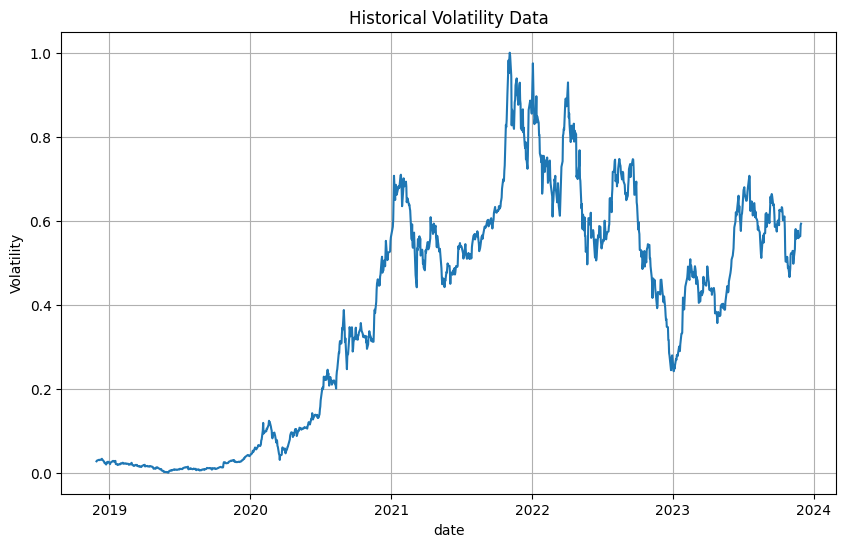

In [21]:
# Plotting the stock’s closing prices over time
plt.figure(figsize=(10, 6))
plt.plot(df_scaled.index, df_scaled["Close"])
plt.xlabel("date")
plt.ylabel("Volatility")
plt.title("Historical Volatility Data")
plt.grid(True)

plt.show()

1. The line plot provides a visual representation of the volatility data over time. 
2. It helps us identify any trends, seasonality, or outliers present in the data.

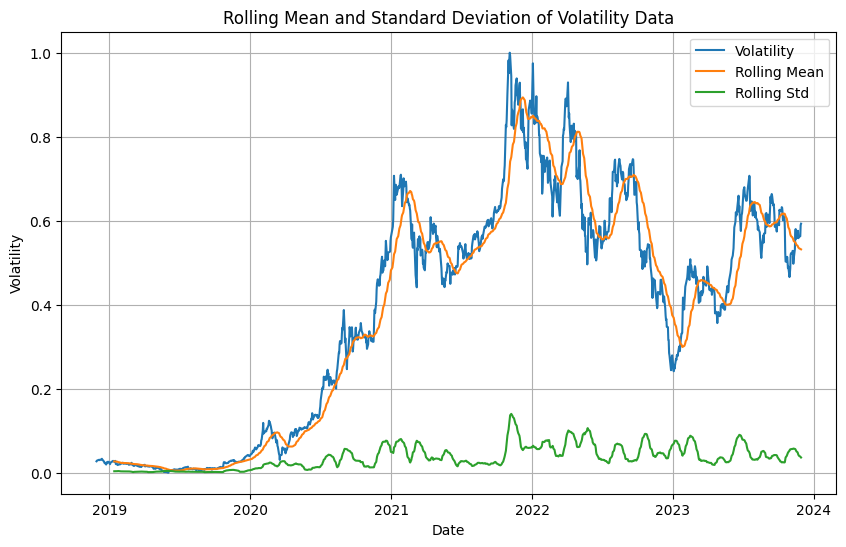

In [22]:
# Calculate the rolling mean and standard deviation
rolling_mean = df_scaled["Close"].rolling(window=30).mean() # 30 dats
rolling_std = df_scaled["Close"].rolling(window=30).std()

# Plot the rolling mean and standard deviation
plt.figure(figsize=(10, 6))
plt.plot(df_scaled.index, df_scaled["Close"], label="Volatility")
plt.plot(rolling_mean.index, rolling_mean, label="Rolling Mean")
plt.plot(rolling_std.index, rolling_std, label="Rolling Std")
plt.xlabel("Date")
plt.ylabel("Volatility")
plt.title("Rolling Mean and Standard Deviation of Volatility Data")
plt.legend()
plt.grid(True)

plt.show()

1. (rolling mean) smooths out fluctuations, making trends clearer
2. the data is highly volatile after 2020

In [23]:
def compute_RSI(df, window=14):
    delta = df["Close"].diff(1)  # Price change
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()

    RS = gain / loss
    RSI = 100 - (100 / (1 + RS))
    
    return RSI

df["RSI_14"] = compute_RSI(df, window=14)  # RSI for Closing Price

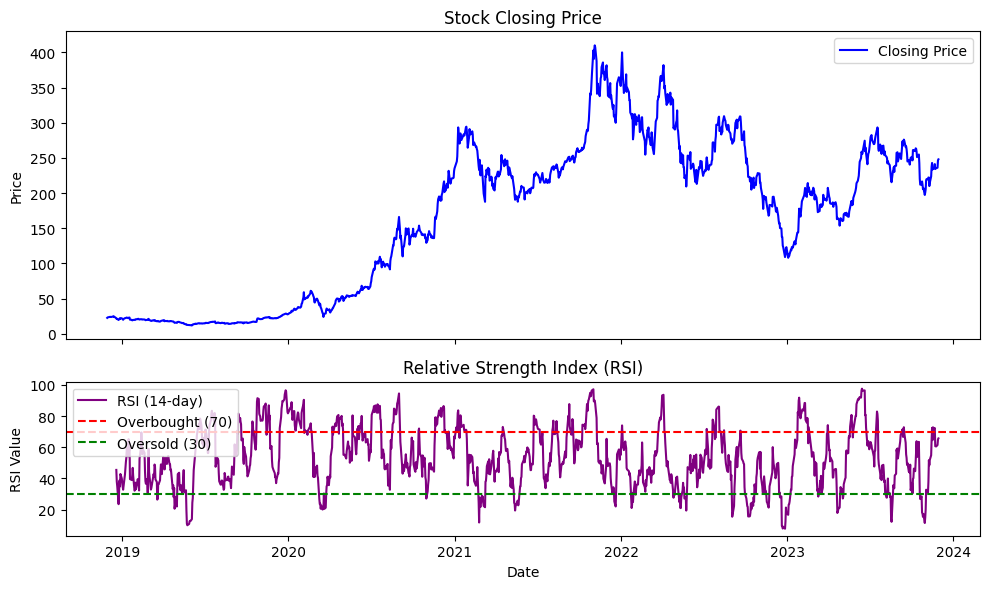

In [48]:
import matplotlib.pyplot as plt

# Create a figure with two subplots
fig, ax = plt.subplots(2, 1, figsize=(10, 6), sharex=True, gridspec_kw={'height_ratios': [2, 1]})

# 🎯 1. Plot Closing Price
ax[0].plot(df.index, df["Close"], label="Closing Price", color="blue")
ax[0].set_title("Stock Closing Price")
ax[0].set_ylabel("Price")
ax[0].legend()

# 🎯 2. Plot RSI
ax[1].plot(df.index, df["RSI_14"], label="RSI (14-day)", color="purple")
ax[1].axhline(70, linestyle="--", color="red", label="Overbought (70)")
ax[1].axhline(30, linestyle="--", color="green", label="Oversold (30)")
ax[1].set_title("Relative Strength Index (RSI)")
ax[1].set_ylabel("RSI Value")
ax[1].legend()

plt.xlabel("Date")
plt.tight_layout()
plt.show()


around  2020, 2021 and after mid 2019 it seems stocks were overbrought oftenly whereas around 2022, 2023, 2024 stocks were oversold 

# Model Building 

In [25]:
# Calculate log returns
returns = np.log(df_scaled["Close"]).diff().dropna()
returns

Date
2018-11-30    0.055811
2018-12-03    0.045645
2018-12-04    0.006718
2018-12-06    0.018421
2018-12-07   -0.028039
                ...   
2023-11-22   -0.030963
2023-11-24    0.005563
2023-11-27    0.002815
2023-11-28    0.046376
2023-11-29    0.005217
Name: Close, Length: 1257, dtype: float64

In [29]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(returns)
print('ADF Statistic:', result[0])
print('p-value:', result[1])


ADF Statistic: -21.759165339449172
p-value: 0.0


# Experimenting with ARCH(1) model

In [35]:
# Fit an ARCH(1) model to the returns data
model_arch = arch_model(returns, vol='ARCH', p=1)  # p=1 for ARCH(1)
model_fit_arch = model_arch.fit()
# Output the model summary
print(model_fit_arch.summary())

Iteration:      1,   Func. Count:      5,   Neg. LLF: 155566430.6850681
Iteration:      2,   Func. Count:     16,   Neg. LLF: -785.5097427556393
Iteration:      3,   Func. Count:     20,   Neg. LLF: 4586.671782124355
Iteration:      4,   Func. Count:     29,   Neg. LLF: 33.91549726992588
Iteration:      5,   Func. Count:     38,   Neg. LLF: -1136.1682469637312
Iteration:      6,   Func. Count:     42,   Neg. LLF: -1140.781073543805
Iteration:      7,   Func. Count:     46,   Neg. LLF: -1141.5257593400793
Iteration:      8,   Func. Count:     50,   Neg. LLF: -1141.9557792649716
Iteration:      9,   Func. Count:     54,   Neg. LLF: -1142.0105832089075
Iteration:     10,   Func. Count:     58,   Neg. LLF: -1142.0106628526921
Iteration:     11,   Func. Count:     62,   Neg. LLF: 1028.2186477952926
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1142.0106628664353
            Iterations: 12
            Function evaluations: 70
            Gradient 

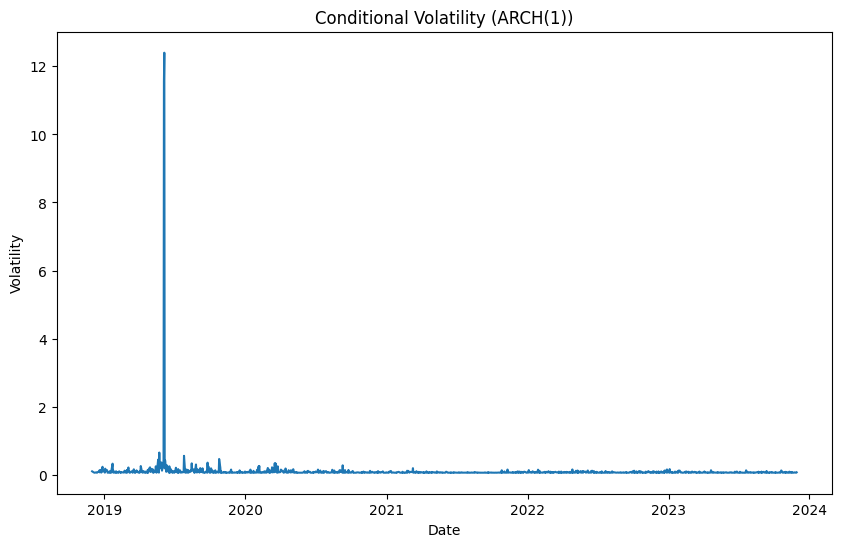

In [32]:
volatility_arch = model_fit_arch.conditional_volatility
# Plot the conditional volatility (estimated volatility)
plt.figure(figsize=(10, 6))
plt.plot(volatility_arch)
plt.title('Conditional Volatility (ARCH(1))')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.show()

In [33]:
# Calculate the mean absolute error (MAE)
mae = np.mean(np.abs(model_fit_arch.conditional_volatility - returns))
print("Mean Absolute Error (MAE):", mae)

# Calculate the root mean squared error (RMSE)
rmse = np.sqrt(np.mean((model_fit_arch.conditional_volatility - returns) ** 2))
print("Root Mean Squared Error (RMSE):", rmse)


Mean Absolute Error (MAE): 0.10555490913231783
Root Mean Squared Error (RMSE): 0.4960106211554048


# Experimenting with ARCH(2)

In [34]:
model_arch2 = arch_model(returns.dropna(), vol="ARCH", p=2)
model_fit_arch2 = model_arch2.fit()
print(model_fit_arch2.summary())

Iteration:      1,   Func. Count:      6,   Neg. LLF: 601049982.1817628
Iteration:      2,   Func. Count:     20,   Neg. LLF: -1088.2872061138683
Iteration:      3,   Func. Count:     25,   Neg. LLF: 806.1586720318426
Iteration:      4,   Func. Count:     34,   Neg. LLF: -338.72049325381346
Iteration:      5,   Func. Count:     42,   Neg. LLF: 574.4692697576974
Iteration:      6,   Func. Count:     49,   Neg. LLF: 2453.6742600431294
Iteration:      7,   Func. Count:     55,   Neg. LLF: -1176.2798426981058
Iteration:      8,   Func. Count:     60,   Neg. LLF: -1177.025616214606
Iteration:      9,   Func. Count:     65,   Neg. LLF: -1177.2213501374663
Iteration:     10,   Func. Count:     70,   Neg. LLF: -1177.2528270742423
Iteration:     11,   Func. Count:     75,   Neg. LLF: -1177.260156414196
Iteration:     12,   Func. Count:     80,   Neg. LLF: -1177.26047643305
Iteration:     13,   Func. Count:     85,   Neg. LLF: -1177.2607694804292
Iteration:     14,   Func. Count:     90,   Neg. 

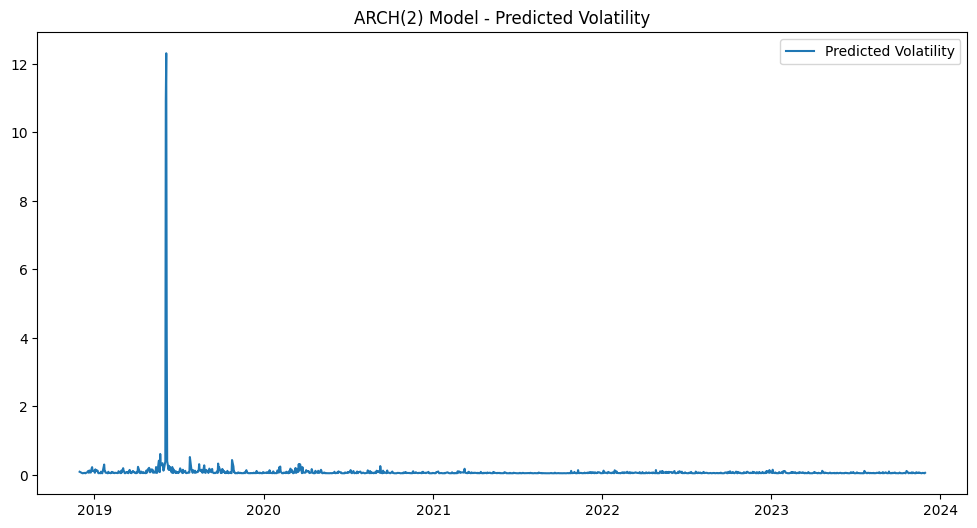

In [36]:
plt.figure(figsize=(12, 6))
plt.plot(model_fit_arch2.conditional_volatility, label="Predicted Volatility")
plt.legend()
plt.title("ARCH(2) Model - Predicted Volatility")
plt.show()

In [37]:
# Calculate the mean absolute error (MAE)
mae = np.mean(np.abs(model_fit_arch2.conditional_volatility - returns))
print("Mean Absolute Error (MAE):", mae)

# Calculate the root mean squared error (RMSE)
rmse = np.sqrt(np.mean((model_fit_arch2.conditional_volatility - returns) ** 2))
print("Root Mean Squared Error (RMSE):", rmse)

Mean Absolute Error (MAE): 0.10333332026387242
Root Mean Squared Error (RMSE): 0.5048945522557144


# Determining p and q value for garch model 

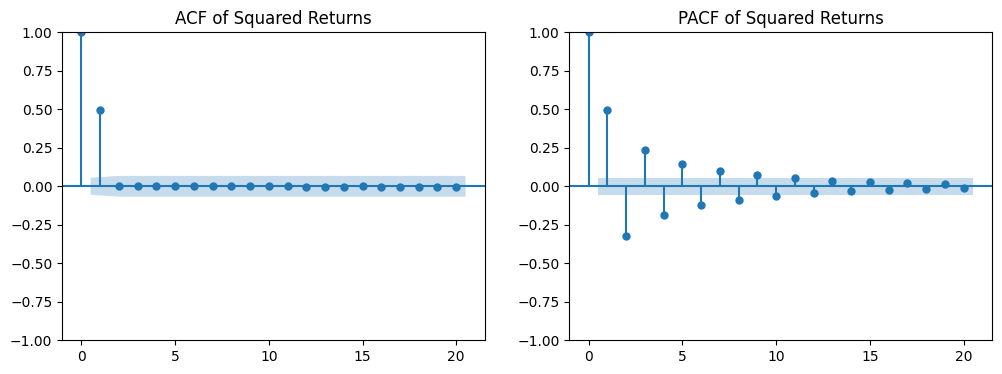

In [43]:
# Plot ACF and PACF of squared returns
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

plot_acf(returns**2, lags=20, ax=axes[0])
axes[0].set_title("ACF of Squared Returns")

plot_pacf(returns**2, lags=20, ax=axes[1])
axes[1].set_title("PACF of Squared Returns")

plt.show()

garch(1,1) model must work will experiment with both (1,1) and (2,2)

# Experimenting with GARCH(1,1)

In [38]:
model_garch = arch_model(returns.dropna(), vol="GARCH", p=1, q=1)
model_fit_garch = model_garch.fit()
print(model_fit_garch.summary())

Iteration:      1,   Func. Count:      6,   Neg. LLF: 30738968.249777284
Iteration:      2,   Func. Count:     19,   Neg. LLF: -1083.5300463465521
Iteration:      3,   Func. Count:     24,   Neg. LLF: -593.1917468057038
Iteration:      4,   Func. Count:     38,   Neg. LLF: 54132.597015668485
Iteration:      5,   Func. Count:     44,   Neg. LLF: 3697.9492098905303
Iteration:      6,   Func. Count:     50,   Neg. LLF: 3020.4390889574997
Iteration:      7,   Func. Count:     57,   Neg. LLF: 494750.90612419567
Iteration:      8,   Func. Count:     63,   Neg. LLF: -797.1961461089327
Iteration:      9,   Func. Count:     70,   Neg. LLF: 3626.3932158222124
Iteration:     10,   Func. Count:     76,   Neg. LLF: -1144.3175899289718
Iteration:     11,   Func. Count:     81,   Neg. LLF: -1144.5712117347712
Iteration:     12,   Func. Count:     86,   Neg. LLF: -1144.6754080921985
Iteration:     13,   Func. Count:     91,   Neg. LLF: -1145.2090210596052
Iteration:     14,   Func. Count:     96,   Ne

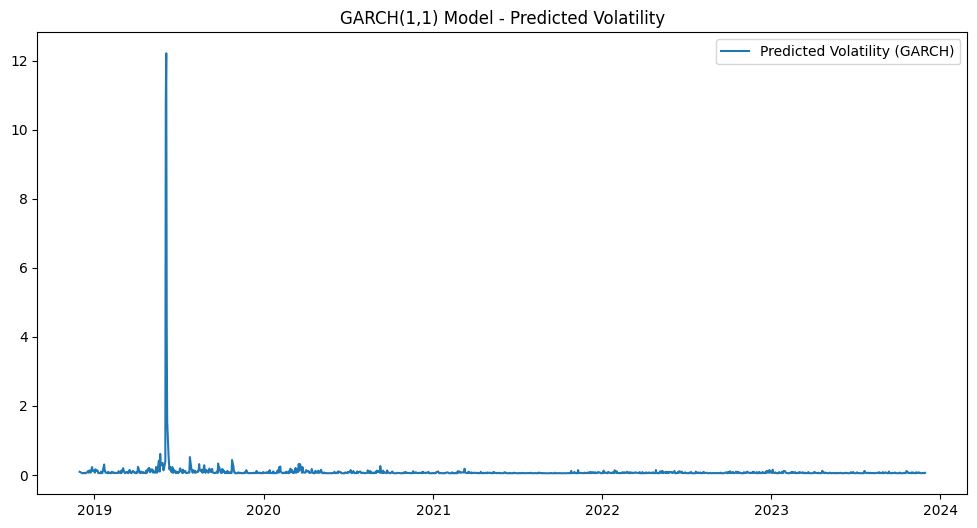

In [39]:
plt.figure(figsize=(12, 6))
plt.plot(model_fit_garch.conditional_volatility, label="Predicted Volatility (GARCH)")
plt.legend()
plt.title("GARCH(1,1) Model - Predicted Volatility")
plt.show()

In [40]:
# Calculate the mean absolute error (MAE)
mae = np.mean(np.abs(model_fit_garch.conditional_volatility - returns))
print("Mean Absolute Error (MAE):", mae)

# Calculate the root mean squared error (RMSE)
rmse = np.sqrt(np.mean((model_fit_garch.conditional_volatility - returns) ** 2))
print("Root Mean Squared Error (RMSE):", rmse)


Mean Absolute Error (MAE): 0.10372807602700009
Root Mean Squared Error (RMSE): 0.5062969778477026


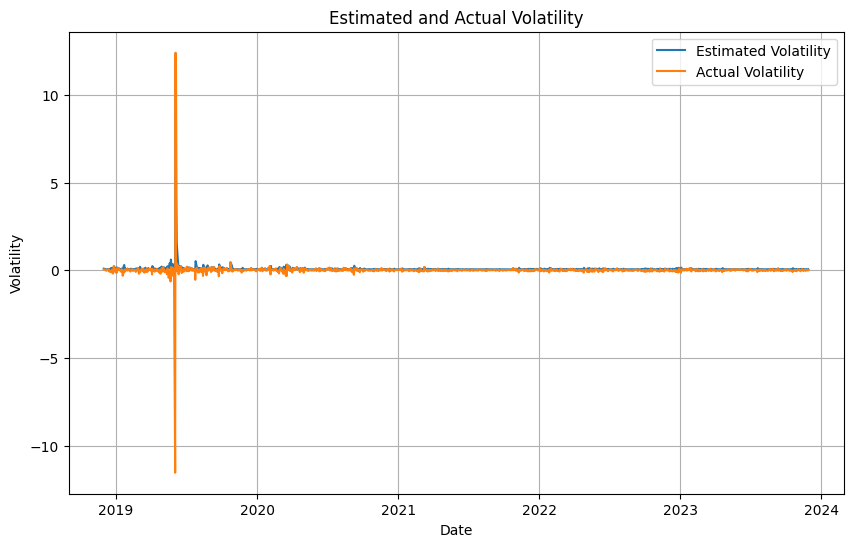

In [41]:
# Plot the estimated and actual volatility
plt.figure(figsize=(10, 6))
plt.plot(model_fit_garch.conditional_volatility.index, model_fit_garch.conditional_volatility, label="Estimated Volatility")
plt.plot(returns.index, returns, label="Actual Volatility")
plt.xlabel("Date")
plt.ylabel("Volatility")
plt.title("Estimated and Actual Volatility")
plt.legend()
plt.grid(True)

plt.show()

# Experimenting with GARCH(2,2)

In [44]:
model_garch2 = arch_model(returns.dropna(), vol="GARCH", p=2, q=2)
model_fit_garch2 = model_garch2.fit()
print(model_fit_garch2.summary())

Iteration:      1,   Func. Count:      8,   Neg. LLF: 442295537.5260003
Iteration:      2,   Func. Count:     23,   Neg. LLF: -377.6745413972699
Iteration:      3,   Func. Count:     30,   Neg. LLF: -444.0571303381633
Iteration:      4,   Func. Count:     43,   Neg. LLF: 1269.1001634594268
Iteration:      5,   Func. Count:     52,   Neg. LLF: 68145.25688033493
Iteration:      6,   Func. Count:     60,   Neg. LLF: 87564431.4826945
Iteration:      7,   Func. Count:     74,   Neg. LLF: 153.27227285390188
Iteration:      8,   Func. Count:     82,   Neg. LLF: 490338.3998830011
Iteration:      9,   Func. Count:     94,   Neg. LLF: -1058.684900834603
Iteration:     10,   Func. Count:    101,   Neg. LLF: 3642.432094690186
Iteration:     11,   Func. Count:    110,   Neg. LLF: -354.158711550666
Iteration:     12,   Func. Count:    120,   Neg. LLF: 548.5611470403162
Iteration:     13,   Func. Count:    128,   Neg. LLF: -1034.5929746398224
Iteration:     14,   Func. Count:    136,   Neg. LLF: -455

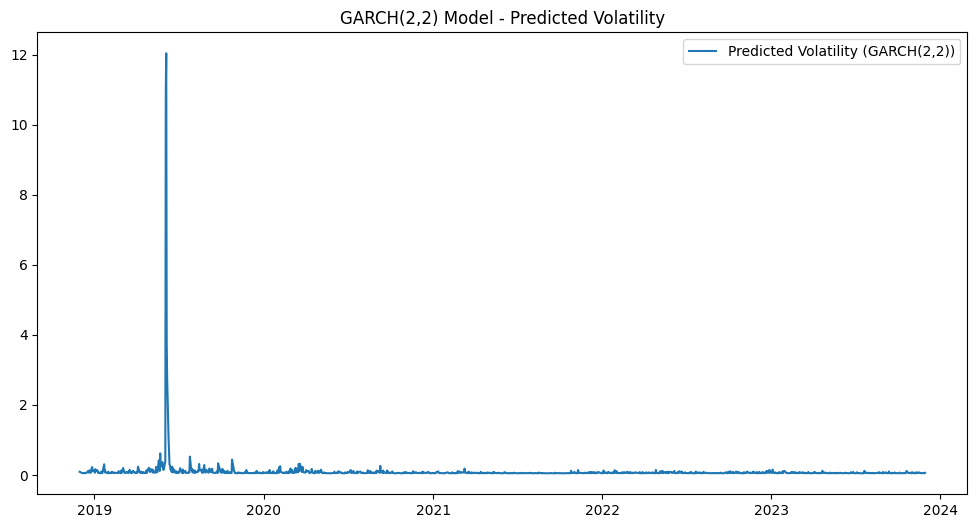

In [45]:
plt.figure(figsize=(12, 6))
plt.plot(model_fit_garch2.conditional_volatility, label="Predicted Volatility (GARCH(2,2))")
plt.legend()
plt.title("GARCH(2,2) Model - Predicted Volatility")
plt.show()

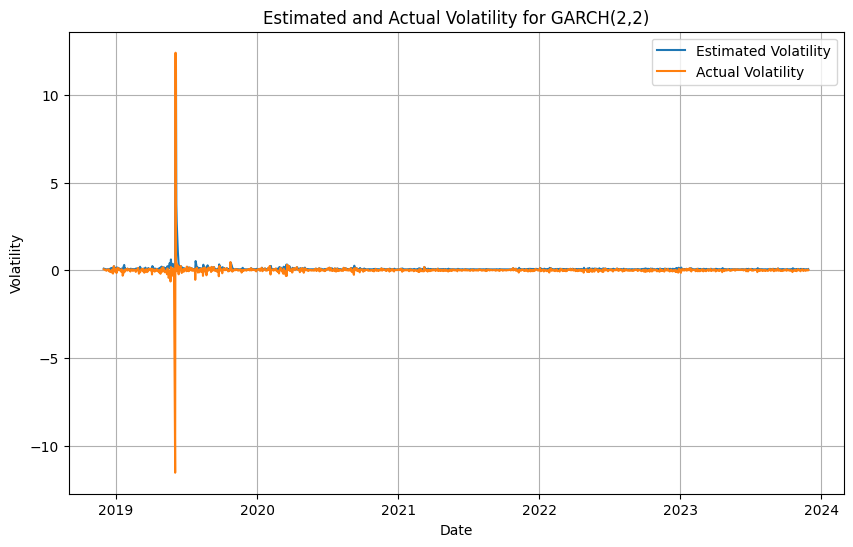

In [46]:
# Plot the estimated and actual volatility
plt.figure(figsize=(10, 6))
plt.plot(model_fit_garch2.conditional_volatility.index, model_fit_garch2.conditional_volatility, label="Estimated Volatility")
plt.plot(returns.index, returns, label="Actual Volatility")
plt.xlabel("Date")
plt.ylabel("Volatility")
plt.title("Estimated and Actual Volatility for GARCH(2,2)")
plt.legend()
plt.grid(True)

plt.show()

In [47]:
# Calculate the mean absolute error (MAE)
mae = np.mean(np.abs(model_fit_garch2.conditional_volatility - returns))
print("Mean Absolute Error (MAE):", mae)

# Calculate the root mean squared error (RMSE)
rmse = np.sqrt(np.mean((model_fit_garch2.conditional_volatility - returns) ** 2))
print("Root Mean Squared Error (RMSE):", rmse)

Mean Absolute Error (MAE): 0.10483476581090873
Root Mean Squared Error (RMSE): 0.5044373658509731


# Comparison of Models 
1. ARCH(2)
- AIC: -2346.52
- BIC: -2325.98
- Mean Absolute Error (MAE): 0.10333332026387242
- Root Mean Squared Error (RMSE): 0.5048945522557144

2. Garch(1,1)
- AIC:  -2360.48
- BIC:  -2339.94
- Mean Absolute Error (MAE): 0.10372807602700009
- Root Mean Squared Error (RMSE): 0.5062969778477026

3. Garch(2,2)
- AIC: -2369.48
- BIC:  -2338.66
- Mean Absolute Error (MAE): 0.10483476581090873
- Root Mean Squared Error (RMSE): 0.5044373658509731

4. The GARCH(2,2) model has a better (lower) AIC value and slightly better RMSE, suggesting it might provide a marginally better fit to the data. But for GARCH(2,2) the BIC is slightly worse and MAE is slightly worse as well

5. Garch(1,1) model should be opted according to the acf and pacf plots.
